# Temporal Stability Evaluation

The main goal of the temporal stability research area is to explore the temporal patterns present in the dataset. We explore the presence of the temporal behavior pattern at the host level and investigate whether it is possible to label the hosts based on the temporal pattern. The stability of the labeling, i.e., the stability of the temporal patterns in host behavior, is investigated as well.

In our study, we choose to explore the following temporal behavior patterns: (1) diurnal pattern that should be significant for human-operated hosts or servers hosting services used mostly by humans from a similar timezone, (2) weekday pattern where we should be able to differentiate between business days and weekend.

### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ipaddress

from IPython.display import clear_output

import calendar

%matplotlib inline

### Load the dataset

In [2]:
print("This may take a while - approx 20 min - We suggest use  pickle for faster load")
file = '../dataset/Flows-anon.csv'
#df = pd.read_csv(file, header=[0], index_col=[0])
#df.index = pd.to_datetime(df.index)

file = '../dataset/precomputed/Flows-anon.pkl'
df = pd.read_pickle(file)

df.head()

This may take a while - approx 20 min - We suggest use  pickle for faster load


,133.250.0.0,133.250.0.1,133.250.0.2,133.250.0.3,133.250.0.4,133.250.0.5,133.250.0.6,133.250.0.7,133.250.0.8,133.250.0.9,...,133.250.255.246,133.250.255.247,133.250.255.248,133.250.255.249,133.250.255.250,133.250.255.251,133.250.255.252,133.250.255.253,133.250.255.254,133.250.255.255
2019-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,48.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,55.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,43.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 03:00:00+00:00,NaN,NaN,NaN,NaN,NaN,1.0,43.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 04:00:00+00:00,NaN,NaN,NaN,NaN,NaN,2.0,71.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Definitions

In [3]:
servers = [ipaddress.ip_network('133.250.178.0/24'), ipaddress.ip_network('133.250.163.0/24')]
workstations = [ipaddress.ip_network('133.250.146.0/24'), ipaddress.ip_network('133.250.157.128/25')]

# List of missing observations and days with missing observations
missing_observations = df[df.isnull().all(axis=1)].index
list_of_missing_days = []
for obs in missing_observations:
    if obs.round(freq='D') not in list_of_missing_days:
        list_of_missing_days.append(obs.round(freq='D'))


In [4]:
def return_selected_columns(list_of_network_ranges, columns):
    """
    Returns list of the selected IP addresses from the list of the network ranges. 
    The goal is to be able to select the subset of the original dataset based on 
    the list of IP ranges
    """
    selected_columns = []
    for column in columns:
        column_ip_object = ipaddress.ip_address(column)
        for network_range in list_of_network_ranges:
            if column_ip_object in network_range:
                selected_columns.append(column)
    return(selected_columns)

#### Create datasets for SUB_WORK and SUB_SERV

In [5]:
df_servers = df[return_selected_columns(servers, df.columns)]
df_workstations = df[return_selected_columns(workstations, df.columns)]
print ("Server shape: ", df_servers.shape)
print ("Workstation shape: ", df_workstations.shape)

Server shape:  (8760, 512)
Workstation shape:  (8760, 384)


## Basic Exploration of Temporal Patterns

### Wohle Dataset

In [6]:
# Count number of the IP addresses that communicated for each observation window
df_all = df.dropna(how='all').notnull().astype('int')
df_all["number_comm_ip"] = df_all.apply(lambda x: x.sum(), axis=1)

In [7]:
# Prepare grouping indexes
df_all['day'] = df_all.index.weekday
df_all['month'] = df_all.index.month
df_all['hour'] = df_all.index.hour

#### Diurnal Pattern

In [8]:
# Group dataset and compute mean number of the number of the communicating hosts
grouped = df_all[['hour', 'number_comm_ip']].groupby(['hour']).mean()

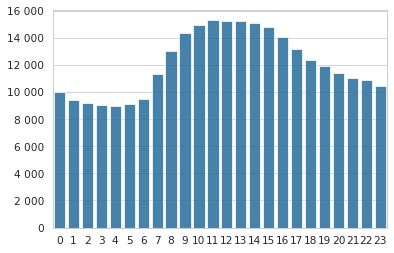

In [9]:
# Plot the data
## Set Style
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2 )

## Plot Data
sns_plot= sns.barplot(x='hour', y="number_comm_ip", data=grouped.reset_index(), color = '#1F77B4', alpha=0.9)

## Set plot properties
sns_plot.set(ylabel = "", xlabel="")
ylabels = ['{:,.0f}'.format(y).replace(',', ' ') for y in sns_plot.get_yticks()]
sns_plot.set_yticklabels(ylabels)


## Show plot
#sns_plot.figure.savefig('./fig/Pattern_weekday.svg')
plt.show()

#### Weekday pattern

In [10]:
# Group dataset and compute mean number of the number of the communicating hosts
grouped = df_all[['day', 'number_comm_ip']].groupby(['day']).mean()

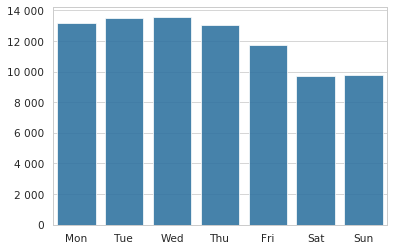

In [11]:
# Plot the data
## Set Style
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2 )

## Plot Data
sns_plot= sns.barplot(x='day', y="number_comm_ip", data=grouped.reset_index(), color = '#1F77B4', alpha=0.9)

# Set plot properties
sns_plot.set(ylabel = "", xlabel="")
ylabels = ['{:,.0f}'.format(y).replace(',', ' ') for y in sns_plot.get_yticks()]
xlabels = [list(calendar.day_abbr)[x] for x in sns_plot.get_xticks()]
sns_plot.set_yticklabels(ylabels)
sns_plot.set_xticklabels(xlabels)

## Show plot
#sns_plot.figure.savefig('./fig/Pattern_weekday.svg')
plt.show()

#### Month Pattern

In [12]:
grouped = df_all[['month', 'number_comm_ip']].groupby(['month']).mean()

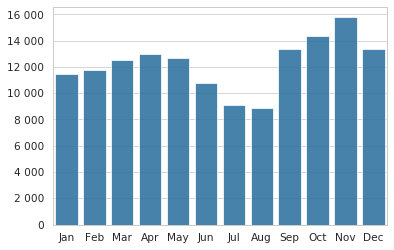

In [13]:
# Plot the data
## Set Style
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2 )

## Plot Data
sns_plot= sns.barplot(x='month', y="number_comm_ip", data=grouped.reset_index(), color = '#1F77B4', alpha=0.9)

## Set plot properties
sns_plot.set(ylabel = "", xlabel="")
ylabels = ['{:,.0f}'.format(y).replace(',', ' ') for y in sns_plot.get_yticks()]
xlabels = [list(calendar.month_abbr)[x+1] for x in sns_plot.get_xticks()]
sns_plot.set_yticklabels(ylabels)
sns_plot.set_xticklabels(xlabels)


## Show plot
#sns_plot.figure.savefig('./fig/Pattern_weekday.svg')
plt.show()

### Selected Subnets

#### Diurnal Pattern

##### Wokrstations

In [14]:
# Count how many times in a year has IP addresses communicated in a given hour of a day
work_count = df_workstations.notnull().astype('int')
work_count['hour']=work_count.index.hour
work_grouped = work_count.groupby('hour').sum()

# Show as percentage of days in year
work_grouped = work_grouped / 365 * 100

# Add hour index for plotting
work_grouped['hour'] = work_grouped.index


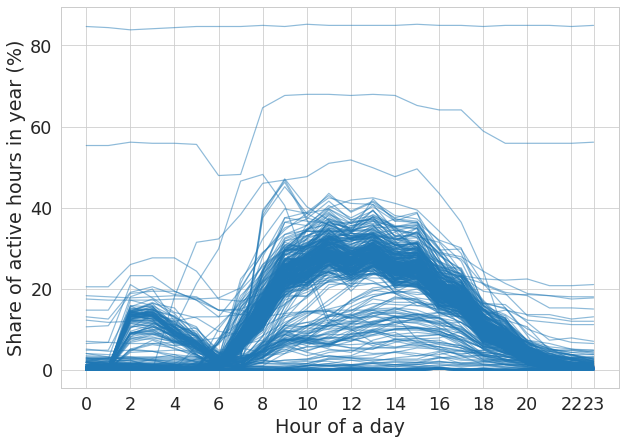

In [15]:
# Plot figure
## Set style
plt.figure(figsize=(10,7))
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2 )

## Print each IP address from subnet
for ip in work_grouped.drop('hour',axis=1).columns:
    sns_plot = sns.lineplot(x='hour', y=ip, data=work_grouped, color = '#1F77B4', alpha=0.5)

## Set plot properties
sns_plot.set(ylabel = "Share of active hours in year (%)", xlabel="Hour of a day")
sns_plot.set_xticks(np.append(np.arange(0, 24, step=2), 23))

## Show plot
#plt.savefig('./fig/day_night_workstations.svg')
plt.show()

##### Servers

In [16]:
# Count how many times in a year has IP addresses communicated in a given hour of a day
server_count = df_servers.notnull().astype('int')
server_count['hour']=server_count.index.hour
server_grouped = server_count.groupby('hour').sum()

# Show as percentage of days in year
server_grouped = server_grouped / 365 * 100

# Add hour index for plotting
server_grouped['hour'] = server_grouped.index

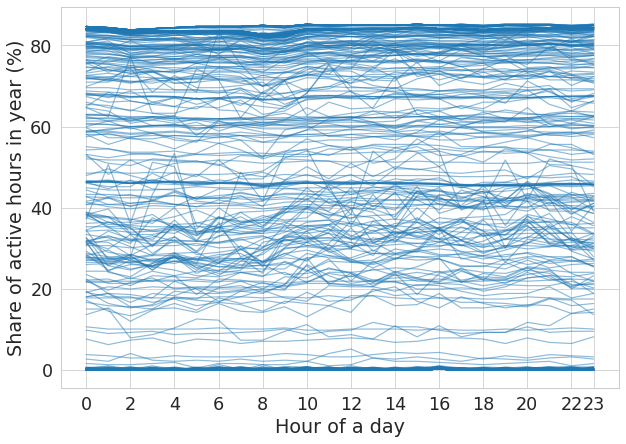

In [17]:
# Plot figure
## Set style
plt.figure(figsize=(10,7))
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2 )

## Print each IP address from subnet
for ip in server_grouped.drop('hour',axis=1).columns:
    sns_plot = sns.lineplot(x='hour', y=ip, data=server_grouped, color = '#1F77B4', alpha=0.5)

## Set plot properties
sns_plot.set(ylabel = "Share of active hours in year (%)", xlabel="Hour of a day")
sns_plot.set_xticks(np.append(np.arange(0, 24, step=2), 23))

## Show plot
#plt.savefig('./fig/day_night_servers.svg')
plt.show()

#### Weekday pattern

##### Workstations

In [18]:
# Count how many times in a year has IP addresses communicated in a given day of a week
work_count = df_workstations.notnull().astype('int')
work_count['day']=work_count.index.weekday
work_grouped = work_count.groupby(['day']).sum()

# Count as a percentage of a days present in week (1248 = 52 weeks * 24 hours in a day)
work_grouped = work_grouped/1248*100

# Add index for plotting
work_grouped['day'] = work_grouped.index


In [ ]:
# Plot figure
## Set style
plt.figure(figsize=(10,7))
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2 )

## Print each IP address from subnet
for ip in work_grouped.drop('day',axis=1).columns:
    sns_plot = sns.lineplot(x='day', y=ip, data=work_grouped, color = '#1F77B4', alpha=0.5)

## Set plot properties
sns_plot.set(ylabel = "Share of active days in year (%)", xlabel="")
labels = [x for x in sns_plot.get_xticks()]
xlabels = [list(calendar.day_abbr)[int(x)] for x in  labels[0:len(labels)-1]]
sns_plot.set_xticklabels(xlabels)

## Show plot
#plt.savefig('./fig/weekday_workstations.svg')
plt.show()

##### Servers

In [ ]:
# Count how many times in a year has IP addresses communicated in a given day of a week
server_count = df_servers.notnull().astype('int')
server_count['day']=server_count.index.weekday
server_grouped = server_count.groupby(['day']).sum()

# Count as a percentage of a days present in week (1248 = 52 weeks * 24 hours in a day)
server_grouped = server_grouped/1248*100

# Add index for plotting
server_grouped['day'] = server_grouped.index

In [ ]:
# Plot figure
## Set style
plt.figure(figsize=(10,7))
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2 )

## Print each IP address from subnet
for ip in server_grouped.drop('day',axis=1).columns:
    sns_plot = sns.lineplot(x='day', y=ip, data=server_grouped, color = '#1F77B4', alpha=0.5)

## Set plot properties
sns_plot.set(ylabel = "Share of active days in year (%)", xlabel="")
labels = [x for x in sns_plot.get_xticks()]
xlabels = [list(calendar.day_abbr)[int(x)] for x in  labels[0:len(labels)-1]]
sns_plot.set_xticklabels(xlabels)

## Show plot
#plt.savefig('./fig/weekday_server.svg')
plt.show()

## Cutoff Analysis for Labels

### Day/Night Talker

#### Definitions

In [22]:
statistics_day = ['day_hours_by_day_mean', 'day_hours_mean', 'day_hours_median', 'day_hours_most_frequent_value']
statistics_night = ['night_hours_by_day_mean', 'night_hours_mean', 'night_hours_median', 'night_hours_most_frequent_value']

In [23]:
def by_day_mean(series):
    """
    Ignores days, where no communication has been done and do not add them into mean
    """
    sum = 0
    cnt = 0
    for i in series:
        if i != 0:
            sum = sum+i
            cnt += 1
    if cnt > 0:
        avg = sum/cnt
    else:
        avg = float('nan')
    return avg

def most_frequent_value(series):
    """
    Returns the most frequent value in the serie
    """
    return np.bincount(series).argmax()

# Labeling functions
def label_day_night_talker(row, cutoff, statistics):
    """
    Function for labeling a day/night talkers. If statistics is greater than cutoff, mark as talker.
    """
    if row[statistics] >= cutoff:
        return 1
    else: 
        return 0
    
def weighted_label_day_night_talker(series, hours, statistics):
    """
    Weighted labeling of the talkers - 3 out of 4 averaging methods must aggree on the label.
    """
    decision = 0
    for statistic in statistics:
        if series[statistic] >= hours:
            decision += 1
    if decision >= 3:
        return 1
    else:
        return 0
    
def label_night_talker_only(row):
    """
    Label hosts, that are night talkers and are not day talkers.
    """
    if row['day_talker'] == 0 and row['night_talker']==1:
        return 1
    else: 
        return 0

def label_day_talker_only(row):
    """
    Label hosts, that are not night talkers and are day talkers.
    """
    if row['day_talker'] == 1 and row['night_talker']==0:
        return 1
    else: 
        return 0

def label_day_night_talker_unknown(row):
    """
    Label hosts, that have no label
    """
    if row['day_talker'] == 0 and row['night_talker']==0:
        return 1
    else: 
        return 0

#### Analysis

In [24]:
# Create column for dan/night definition
df['hour'] = df.index.hour

# Select observations belonging to day and belonging to night 
day_hours = df[(df['hour'] >= 6) & (df['hour'] < 18)]
night_hours = df[(df['hour'] < 6) | (df['hour'] >= 18)]
day_hours = day_hours.drop('hour',axis=1)
night_hours = night_hours.drop('hour',axis=1)

print("Day hours shape: ", day_hours.shape)
print("Night hours shape: ", night_hours.shape)



Day hours shape:  (4380, 65536)
Night hours shape:  (4380, 65536)


In [25]:
# Count how many of the day/night hours has an IP communicated in each day of the year
day_hours_agg = day_hours.resample('D').count()
day_hours_agg = day_hours_agg.drop(list_of_missing_days)
night_hours_agg = night_hours.resample('D').count()
night_hours_agg = night_hours_agg.drop(list_of_missing_days)
print('Aggregated day hours shape: ', day_hours_agg.shape)
print('Aggregated night hours shape: ', night_hours_agg.shape)

Aggregated day hours shape:  (301, 65536)
Aggregated night hours shape:  (301, 65536)


In [26]:
# Compute aggregated IP characteristics for day hours using different aggregation methods
ip_characteristics = pd.DataFrame(index=day_hours_agg.columns)

## Mean with NA values not counted
ip_characteristics['day_hours_by_day_mean'] = day_hours_agg.apply(by_day_mean)
## Median
ip_characteristics['day_hours_median'] = day_hours_agg.median()
## Native mean implementation
ip_characteristics['day_hours_mean'] = day_hours_agg.mean()
## Most frequent value
ip_characteristics['day_hours_most_frequent_value'] = day_hours_agg.apply(most_frequent_value)

# Compute aggregated IP characteristics for day hours using different aggregation methods
## Mean with NA values not counted
ip_characteristics['night_hours_by_day_mean'] = night_hours_agg.apply(by_day_mean)
## Median
ip_characteristics['night_hours_median'] = night_hours_agg.median()
## Native mean implementation
ip_characteristics['night_hours_mean'] = night_hours_agg.mean()
## Most frequent value
ip_characteristics['night_hours_most_frequent_value'] = night_hours_agg.apply(most_frequent_value)

##### Distributions of IP characteristics

Day hours:

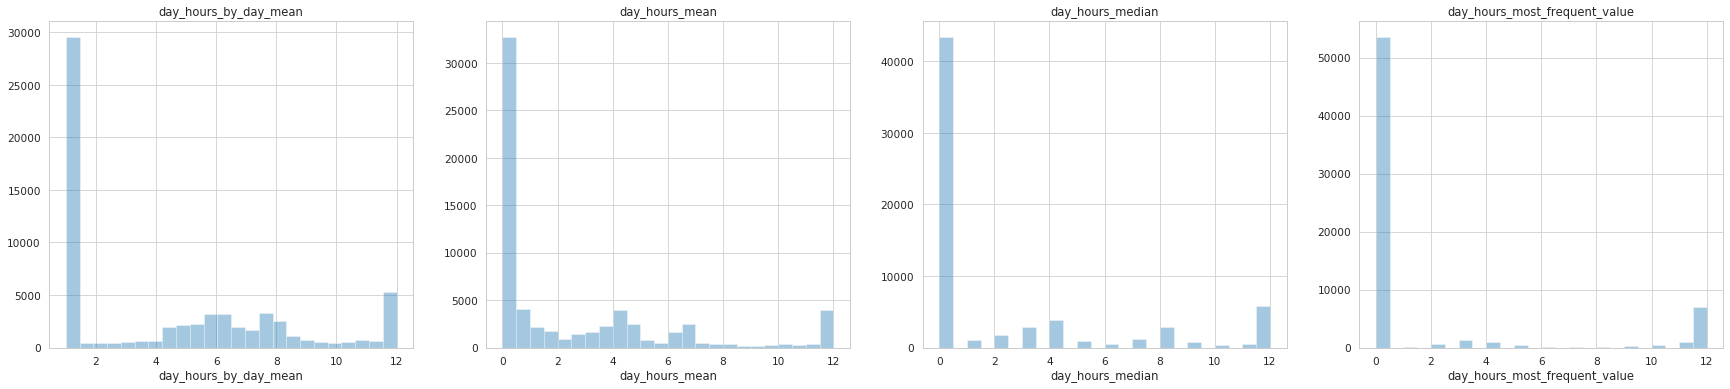

In [27]:
# Plot setup
f,axs = plt.subplots(1,4,figsize=(30,6))
cnt = 0

# Plot all computed statistics 
for statistics in statistics_day:
    cnt += 1
    sns.distplot(ip_characteristics[statistics].dropna(), kde=False, bins=24,ax=axs[cnt-1])
    axs[cnt-1].set_title(statistics)

plt.show()

Night hours

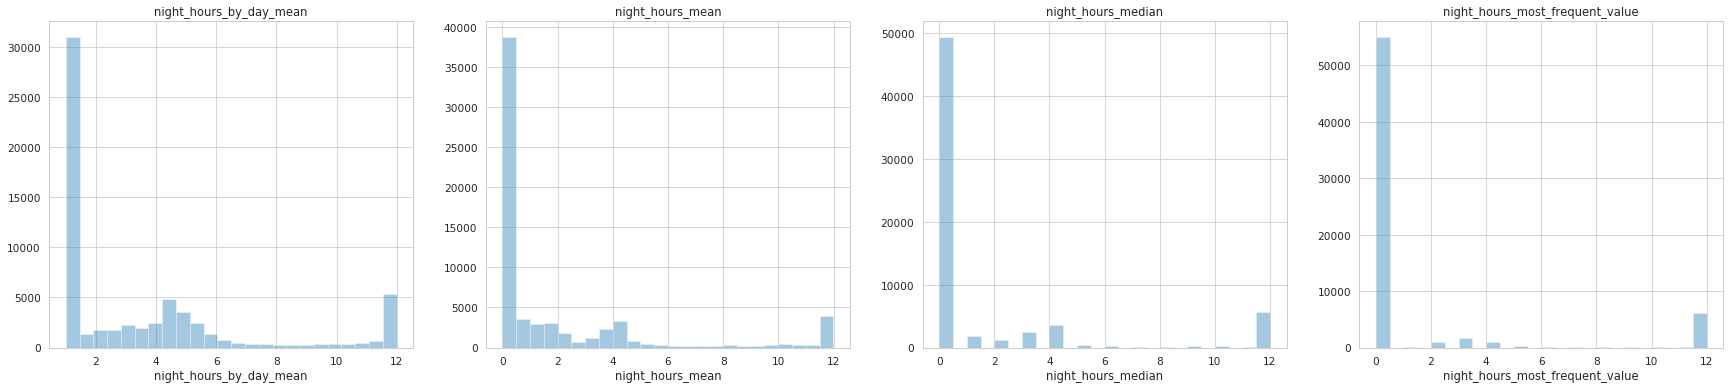

In [28]:
# Plot setup
f,axs = plt.subplots(1,4,figsize=(30,6))
cnt = 0

# Plot all computed statistics
for statistics in statistics_night:
    cnt += 1
    sns.distplot(ip_characteristics[statistics].dropna(), kde=False, bins=24,ax=axs[cnt-1])
    axs[cnt-1].set_title(statistics)

plt.show()

Computation of the number of **Day Talkers** for different values of cutoff (0,0.5,1,1.5,...,12)

In [29]:
# Create dataframe for cutoff output and its columns
columns = ['Cutoff Hour'] + [s +"_0" for s in statistics_day] + [s +"_1" for s in statistics_day]
cutoff_analysis_day = pd.DataFrame(columns = columns)

# Iterate over different cutoffs
for cutoff in np.arange(0,12.3,.5):
    # Initialize record for cutoff dataframe
    record = {'Cutoff Hour': cutoff}
    # Iterate over different aggregation statistics
    for statistics in statistics_day: 
        # Print progress
        clear_output(wait=True)
        print("Cutoff: %s  Statistics: %s " %(cutoff,statistics))
        
        # Label talkers given the cutoff
        talker = ip_characteristics.apply(lambda row: label_day_night_talker(row,cutoff,statistics), axis =1)
        
        # Compute the number of labeled talkers
        value_counts= talker.value_counts()
        # Store the record
        if 0 in value_counts.keys():
            record[statistics + "_0"] = value_counts[0]    
        else:
            record[statistics + "_0"] = float('NaN')
        if 1 in value_counts.keys():
            record[statistics + "_1"]  = value_counts[1]
        else:
             record[statistics + "_1"] = float('NaN')
        
    cutoff_analysis_day = cutoff_analysis_day.append(pd.DataFrame(record, index = [1]), ignore_index=True)
print('Cutoff analysis finished')

Cutoff: 12.0  Statistics: day_hours_most_frequent_value 
Cutoff analysis finished


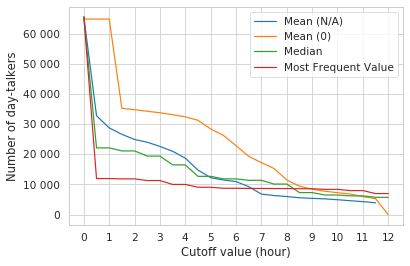

In [30]:
# Plot results
## Set style
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2 )

# Plot data
sns_plot = sns.lineplot(x='Cutoff Hour', y='day_hours_mean_1',data= cutoff_analysis_day.astype(float), label = "Mean (N/A)")
sns_plot = sns.lineplot(x='Cutoff Hour', y='day_hours_by_day_mean_1',data= cutoff_analysis_day.astype(float), label = "Mean (0)")
sns_plot = sns.lineplot(x='Cutoff Hour', y='day_hours_median_1',data= cutoff_analysis_day.astype(float), label = "Median")
sns_plot = sns.lineplot(x='Cutoff Hour', y='day_hours_most_frequent_value_1',data= cutoff_analysis_day.astype(float), label = "Most Frequent Value")

## Set plot properties
ylabels = ['{:,.0f}'.format(y).replace(',', ' ') for y in sns_plot.get_yticks()]
sns_plot.set_yticklabels(ylabels)
sns_plot.set_xticks(np.arange(0, 13, step=1))
sns_plot.set(ylabel = "Number of day-talkers", xlabel="Cutoff value (hour)")

## Show plot
#sns_plot.figure.savefig('./fig/Patterns-cutoff-day-hours.svg')
plt.show()

Computation of the number of **Night Talkers** for different values of cutoff (0,0.5,1,1.5,...,12)

In [31]:
# Create dataframe for cutoff output and its columns
columns = ['Cutoff Hour'] + [s +"_0" for s in statistics_night] + [s +"_1" for s in statistics_night]
cutoff_analysis_night = pd.DataFrame(columns = columns)

# Iterate over different cutoffs
for cutoff in np.arange(0,12.3,.5):
    # Initialize record for cutoff dataframe
    record = {'Cutoff Hour': cutoff}
    # Iterate over different aggregation statistics
    for statistics in statistics_night: 
        # Print progress
        clear_output(wait=True)
        print("Cutoff: %s  Statistics: %s " %(cutoff,statistics))
        
        # Label talkers given the cutoff
        talker = ip_characteristics.apply(lambda row: label_day_night_talker(row,cutoff,statistics), axis =1)
        
        # Compute the number of labeled talkers
        value_counts= talker.value_counts()
        # Store the record
        if 0 in value_counts.keys():
            record[statistics + "_0"] = value_counts[0]    
        else:
            record[statistics + "_0"] = float('NaN')
        if 1 in value_counts.keys():
            record[statistics + "_1"]  = value_counts[1]
        else:
             record[statistics + "_1"] = float('NaN')
        
    cutoff_analysis_night = cutoff_analysis_night.append(pd.DataFrame(record, index = [1]), ignore_index=True)
print('Cutoff analysis finished')

Cutoff: 12.0  Statistics: night_hours_most_frequent_value 
Cutoff analysis finished


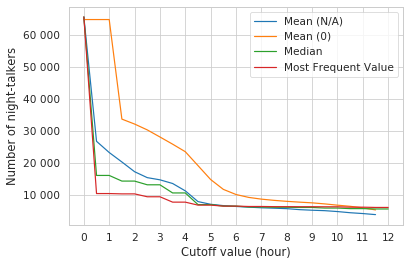

In [32]:
# Plot results
## Set style
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2 )

# Plot data
sns_plot = sns.lineplot(x='Cutoff Hour', y='night_hours_mean_1',data= cutoff_analysis_night.astype(float), label = "Mean (N/A)")
sns_plot = sns.lineplot(x='Cutoff Hour', y='night_hours_by_day_mean_1',data= cutoff_analysis_night.astype(float), label = "Mean (0)")
sns_plot = sns.lineplot(x='Cutoff Hour', y='night_hours_median_1',data= cutoff_analysis_night.astype(float), label = "Median")
sns_plot = sns.lineplot(x='Cutoff Hour', y='night_hours_most_frequent_value_1',data= cutoff_analysis_night.astype(float), label = "Most Frequent Value")

## Set plot properties
ylabels = ['{:,.0f}'.format(y).replace(',', ' ') for y in sns_plot.get_yticks()]
sns_plot.set_yticklabels(ylabels)
sns_plot.set_xticks(np.arange(0, 13, step=1))
sns_plot.set(ylabel = "Number of night-talkers", xlabel="Cutoff value (hour)")

## Show plot
#sns_plot.figure.savefig('./fig/Patterns-cutoff-night-hours.svg')
plt.show()

Assign the labels based on the selected cutoff

In [33]:
ip_characteristics['day_talker'] = ip_characteristics.apply(lambda row: weighted_label_day_night_talker(row, 6, statistics_day), axis =1)
ip_characteristics['night_talker'] = ip_characteristics.apply(lambda row: weighted_label_day_night_talker(row, 5, statistics_night), axis =1)
ip_characteristics['day_talker_only'] = ip_characteristics.apply(lambda row: label_day_talker_only(row), axis =1)
ip_characteristics['night_talker_only'] = ip_characteristics.apply(lambda row: label_night_talker_only(row), axis =1)
ip_characteristics['day_night_talker_unknown'] = ip_characteristics.apply(lambda row: label_day_night_talker_unknown(row), axis =1)

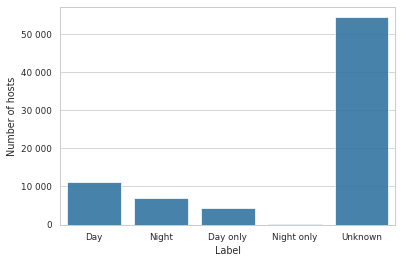

In [34]:
# Plot the restulting distribution of the labels
## Prepare data for ploting
bar=ip_characteristics[['day_talker', 'night_talker',
       'day_talker_only', 'night_talker_only', 'day_night_talker_unknown']]

arrays = []
for char in bar.columns:
    counts = bar[char].value_counts()

    array=[0]*3
    array[0] = char
    array[1] = "yes"
    array[2] = counts[1]
    arrays.append(array)
    array=[0]*3
    array[0] = char
    array[1] = "no"
    array[2] = counts[0]
    arrays.append(array)    
df_bar = pd.DataFrame(arrays, columns=['char', 'Label', 'count'])

## Set plot style
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1)

## Plot the data
sns_plot = sns.barplot(x='char',y='count', data=df_bar[df_bar['Label']=='yes'],  color = '#1F77B4', alpha=0.9)

## Adjust plot properties
ylabels = ['{:,.0f}'.format(y).replace(',', ' ') for y in sns_plot.get_yticks()]
sns_plot.set_yticklabels(ylabels)
sns_plot.set_xticklabels(['Day', 'Night','Day only', 'Night only', 'Unknown'])
sns_plot.set(ylabel = "Number of hosts", xlabel="Label")

## Show plot
#sns_plot.figure.savefig('./fig/Pattern_day_night_value_counts.svg')
plt.show()

### Business day/ Weekend Talker

#### Definitions

In [35]:
statistics_business = ['business_day_by_day_mean','business_day_median', 'business_day_mean', 'business_day_most_frequent_value']
statistics_weekend = ['weekend_by_day_mean','weekend_median', 'weekend_mean', 'weekend_most_frequent_value']

statistics_business_days_talked = ['days_talked_business_day_by_day_mean','days_talked_business_day_median', 'days_talked_business_day_mean', 'days_talked_business_day_most_frequent_value']
statistics_weekend_days_talked = ['days_talked_weekend_by_day_mean','days_talked_weekend_median', 'days_talked_weekend_mean', 'days_talked_weekend_most_frequent_value']

In [36]:
# Labeling functions
def label_business_weekend_talker(row, cutoff, statistics):
    """
    Function for labeling a day/night talkers. If statistics is greater than cutoff, mark as talker.
    """
    if row[statistics] >= cutoff:
        return 1
    else: 
        return 0
    
def weighted_label_business_weekend_talker(series, hours, statistics):
    """
    Weighted labeling of the talkers - 3 out of 4 averaging methods must aggree on the label.
    """
    decision = 0
    for statistic in statistics:
        if series[statistic] >= hours:
            decision += 1
    if decision >= 3:
        return 1
    else:
        return 0

def label_business_weekend_talker_combined(row, hours, days, statistic):
    """
    Labeling based on the combination of the number of hour and days communicated in the business/weekend days
    """
    days_talked_statistics = "days_talked_" + statistic
    if row[statistic] >= hours and row[days_talked_statistics]>= days:
        return 1
    else: 
        return 0

def weighted_label_business_weekend_talker_combined(row, hours, days, statistics):
    """
    Weighted labeling based on the combination of the number of hour and days communicated in the business/weekend days - 3 out of 4 averaging methods must aggree on the label.
    """
    decision = 0
    for statistic in statistics:
        days_talked_statistics = "days_talked_" + statistic
        if row[statistic] >= hours and row[days_talked_statistics]>= days:
            decision += 1
    
    if decision >= 3:
        return 1
    else:
        return 0

def label_all_week_talker(row):
    """
    Label hosts, that are business day and weekend day talker.
    """
    if row['business_day_talker'] == 1 and row['weekend_talker'] == 1:
        return 1
    else: 
        return 0
    
def no_talker(row):
    """
    Label hosts, that are not business day and not weekend day talker.
    """
    if row['business_day_talker'] == 0 and row['weekend_talker'] == 0:
        return 1
    else: 
        return 0

def business_day_talker_only(row):
    """
    Label hosts, that are business day and not weekend day talker.
    """
    if row['business_day_talker'] == 1 and row['weekend_talker'] == 0:
        return 1
    else: 
        return 0

def weekend_talker_only(row):
    """
    Label hosts, that are not business day and are weekend day talker.
    """
    if row['business_day_talker'] == 0 and row['weekend_talker'] == 1:
        return 1
    else: 
        return 0

#### Cutoff Analysis Based on the Average Number of Hours Communicated During the Business Days/Weekend 

In [37]:
# Create datasets for business day and weekends
## Aggregate by day
by_day = df.resample('D').count()
by_day = by_day.drop(list_of_missing_days)

## Select by business days or weekend days
by_day_business = by_day[by_day.index.dayofweek<5]
by_day_weekend = by_day[by_day.index.dayofweek>=5]

print("Business days shapes: ",by_day_business.shape)
print("Weekend days shapes: ",by_day_weekend.shape)

Business days shapes:  (215, 65537)
Weekend days shapes:  (86, 65537)


In [38]:
# Compute aggregated IP characteristics for day hours using different aggregation methods
ip_characteristics = pd.DataFrame(index=by_day_business.columns)

# Business days aggregations for each host
## Mean with NA values not counted
ip_characteristics['business_day_by_day_mean'] = by_day_business.apply(by_day_mean)
## Median
ip_characteristics['business_day_median'] = by_day_business.median()
## Native mean implementation
ip_characteristics['business_day_mean'] = by_day_business.mean()
## Most frequent value
ip_characteristics['business_day_most_frequent_value'] = by_day_business.apply(most_frequent_value)

# Weekend aggregations for each host
## Mean with NA values not counted
ip_characteristics['weekend_by_day_mean'] = by_day_weekend.apply(by_day_mean)
## Median
ip_characteristics['weekend_median'] = by_day_weekend.median()
## Native mean implementation
ip_characteristics['weekend_mean'] = by_day_weekend.mean()
## Most frequent value
ip_characteristics['weekend_most_frequent_value'] = by_day_weekend.apply(most_frequent_value)

##### Distributions of IP characteristics

Business days:

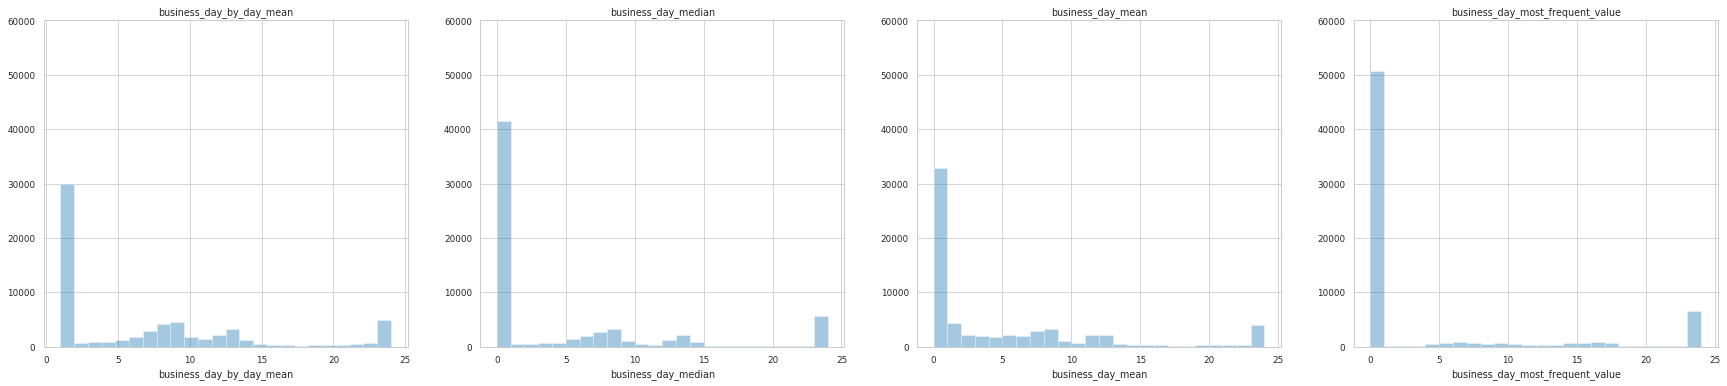

In [39]:
# Plot setup
f,axs = plt.subplots(1,4,figsize=(30,6))

# Plot all computed statistics
cnt = 0
for statistics in statistics_business:
    cnt += 1
    sns.distplot(ip_characteristics[statistics].dropna(), kde=False, bins=24,ax=axs[cnt-1])
    axs[cnt-1].set_title(statistics)
    axs[cnt-1].set_ylim(0, 60000)

plt.show()

Weekend days

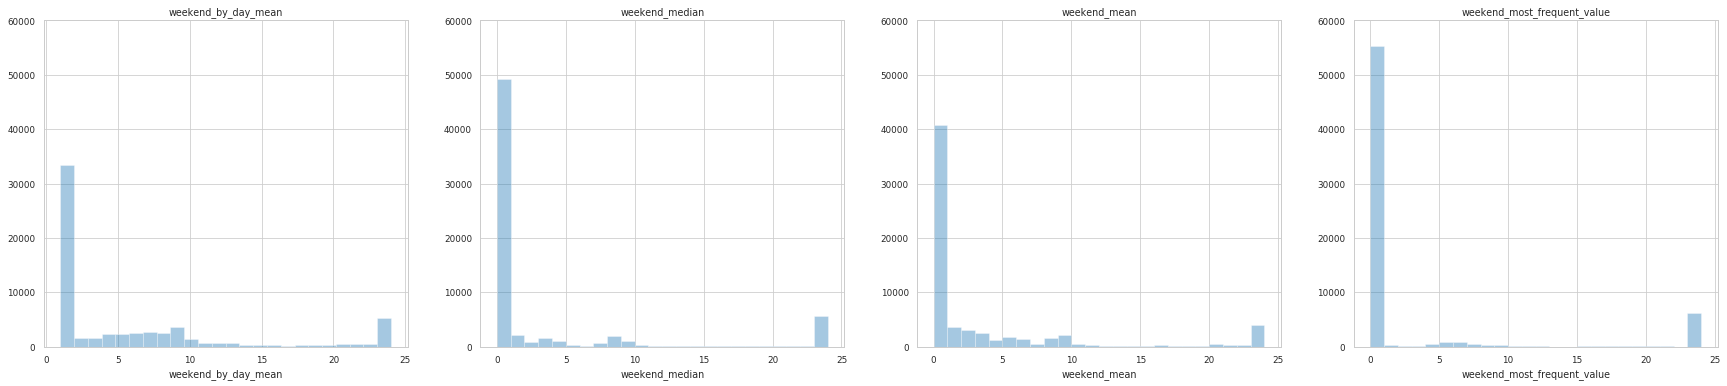

In [40]:
# Plot setup
f,axs = plt.subplots(1,4,figsize=(30,6))

# Plot all computed statistics
cnt = 0
for statistics in statistics_weekend:
    cnt += 1
    sns.distplot(ip_characteristics[statistics].dropna(), kde=False, bins=24,ax=axs[cnt-1])
    axs[cnt-1].set_title(statistics)
    axs[cnt-1].set_ylim(0, 60000)

plt.show()

Computation of the number of **Business Day Talkers** based on the **average number of hours* communicated during the business days for different values of cutoff (0,1,2,...,23)

In [41]:
# Create dataframe for cutoff output and its columns
columns = ['Cutoff Hour'] + [s +"_0" for s in statistics_business] + [s +"_1" for s in statistics_business]
cutoff_analysis_business = pd.DataFrame(columns = columns)

# Iterate over different cutoffs
for cutoff in range(0,24,1):
    # Initialize record for cutoff dataframe
    record = {'Cutoff Hour': cutoff}
    # Iterate over different aggregation statistics
    for statistics in statistics_business:
        # Print progress
        clear_output(wait=True)
        print("Cutoff Hour: %s  Statistics: %s " %(cutoff,statistics))
        # Label hosts based on the cutoff
        talker = ip_characteristics.apply(lambda row: label_business_weekend_talker(row,cutoff,statistics), axis =1)
        # Compute the number of labeled talkers
        value_counts= talker.value_counts()
        # Created the record
        if 0 in value_counts.keys():
            record[statistics + "_0"] = value_counts[0] 
        else:
            record[statistics + "_0"] = 0
        if 1 in value_counts.keys():
            record[statistics + "_1"]  = value_counts[1]
        else:
             record[statistics + "_1"] = 0
        
    cutoff_analysis_business = cutoff_analysis_business.append(pd.DataFrame(record, index = [1]), ignore_index=True)
    
print('Computation finished')

Cutoff Hour: 23  Statistics: business_day_most_frequent_value 
Computation finished


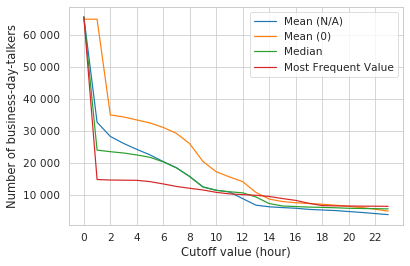

In [42]:
# Plot cutoff analysis results
## Set style
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2 )

## Plot data
sns_plot = sns.lineplot(x='Cutoff Hour', y='business_day_mean_1',data= cutoff_analysis_business.astype(float), label = "Mean (N/A)")
sns_plot = sns.lineplot(x='Cutoff Hour', y='business_day_by_day_mean_1',data= cutoff_analysis_business.astype(float), label = "Mean (0)")
sns_plot = sns.lineplot(x='Cutoff Hour', y='business_day_median_1',data= cutoff_analysis_business.astype(float), label = "Median")
sns_plot = sns.lineplot(x='Cutoff Hour', y='business_day_most_frequent_value_1',data= cutoff_analysis_business.astype(float), label = "Most Frequent Value")

## Adjust plot properties
ylabels = ['{:,.0f}'.format(y).replace(',', ' ') for y in sns_plot.get_yticks()]
sns_plot.set_yticklabels(ylabels)
sns_plot.set_xticks(np.arange(0, 24, step=2))
sns_plot.set(ylabel = "Number of business-day-talkers", xlabel="Cutoff value (hour)")

## Show plot
#sns_plot.figure.savefig('./fig/Patterns-cutoff-weekday.svg')
plt.show()

Computation of the number of **Weekend Talkers** based on the **average number of hours** communicated during the weekend days for different values of cutoff (0,1,2,...,23)

In [43]:
# Create dataframe for cutoff output and its columns
columns = ['Cutoff Hour'] + [s +"_0" for s in statistics_weekend] + [s +"_1" for s in statistics_weekend]
cutoff_analysis_weekend = pd.DataFrame(columns = columns)

# Iterate over different cutoffs
for cutoff in range(0,24,1):
    # Initialize record for cutoff dataframe
    record = {'Cutoff Hour': cutoff}
    # Iterate over different aggregation statistics
    for statistics in statistics_weekend:
        # Print progress
        clear_output(wait=True)
        print("Cutoff Hour: %s  Statistics: %s " %(cutoff,statistics))
        # Label hosts based on the cutoff
        talker = ip_characteristics.apply(lambda row: label_business_weekend_talker(row,cutoff,statistics), axis =1)
        # Compute the number of labeled talkers
        value_counts= talker.value_counts()
        # Created the record
        if 0 in value_counts.keys():
            record[statistics + "_0"] = value_counts[0] 
        else:
            record[statistics + "_0"] = 0
        if 1 in value_counts.keys():
            record[statistics + "_1"]  = value_counts[1]
        else:
             record[statistics + "_1"] = 0
        
    cutoff_analysis_weekend = cutoff_analysis_weekend.append(pd.DataFrame(record, index = [1]), ignore_index=True)
    
print('Computation finished')

Cutoff Hour: 23  Statistics: weekend_most_frequent_value 
Computation finished


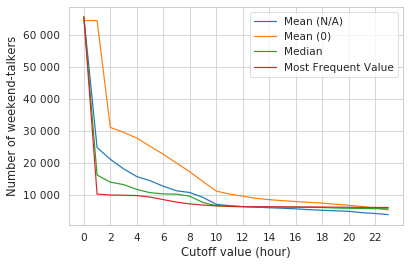

In [44]:
# Plot cutoff analysis results
## Set style
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2 )

## Plot data
sns_plot = sns.lineplot(x='Cutoff Hour', y='weekend_mean_1',data= cutoff_analysis_weekend.astype(float), label = "Mean (N/A)")
sns_plot = sns.lineplot(x='Cutoff Hour', y='weekend_by_day_mean_1',data= cutoff_analysis_weekend.astype(float), label = "Mean (0)")
sns_plot = sns.lineplot(x='Cutoff Hour', y='weekend_median_1',data= cutoff_analysis_weekend.astype(float), label = "Median")
sns_plot = sns.lineplot(x='Cutoff Hour', y='weekend_most_frequent_value_1',data= cutoff_analysis_weekend.astype(float), label = "Most Frequent Value")

## Adjust plot properties
ylabels = ['{:,.0f}'.format(y).replace(',', ' ') for y in sns_plot.get_yticks()]
sns_plot.set_yticklabels(ylabels)
sns_plot.set_xticks(np.arange(0, 24, step=2))
sns_plot.set(ylabel = "Number of weekend-talkers", xlabel="Cutoff value (hour)")

## Show plot
#sns_plot.figure.savefig('./fig/Patterns-cutoff-weekday.svg')
plt.show()

#### Cutoff Analysis Based on the Average Number of Days Communicated During the Business Days/Weekend 

In [45]:
# Prepare dataset for computations
replaced_business = by_day_business.replace(0,float('NaN'))
replaced_business = replaced_business.reset_index()
replaced_business['week_number'] = replaced_business['index'].dt.week
replaced_business = replaced_business.groupby(by='week_number').count()

replaced_weekend = by_day_weekend.replace(0,float('NaN'))
replaced_weekend = replaced_weekend.reset_index()
replaced_weekend['week_number'] = replaced_weekend['index'].dt.week
replaced_weekend = replaced_weekend.groupby(by='week_number').count()


In [46]:
# Compute aggregated IP characteristics for day hours using different aggregation methods
# Business days aggregations for each host
## Mean with NA values not counted
ip_characteristics['days_talked_business_day_by_day_mean'] = replaced_business.apply(by_day_mean)
## Median
ip_characteristics['days_talked_business_day_median'] = replaced_business.median()
## Native mean implementation
ip_characteristics['days_talked_business_day_mean'] = replaced_business.mean()
## Most frequent value
ip_characteristics['days_talked_business_day_most_frequent_value'] = replaced_business.apply(most_frequent_value)

# Weekend days aggregations for each host
## Mean with NA values not counted
ip_characteristics['days_talked_weekend_by_day_mean'] = replaced_weekend.apply(by_day_mean)
## Median
ip_characteristics['days_talked_weekend_median'] = replaced_weekend.median()
## Native mean implementation
ip_characteristics['days_talked_weekend_mean'] = replaced_weekend.mean()
## Most frequent value
ip_characteristics['days_talked_weekend_most_frequent_value'] = replaced_weekend.apply(most_frequent_value)

##### Distributions of IP characteristics

Business days:

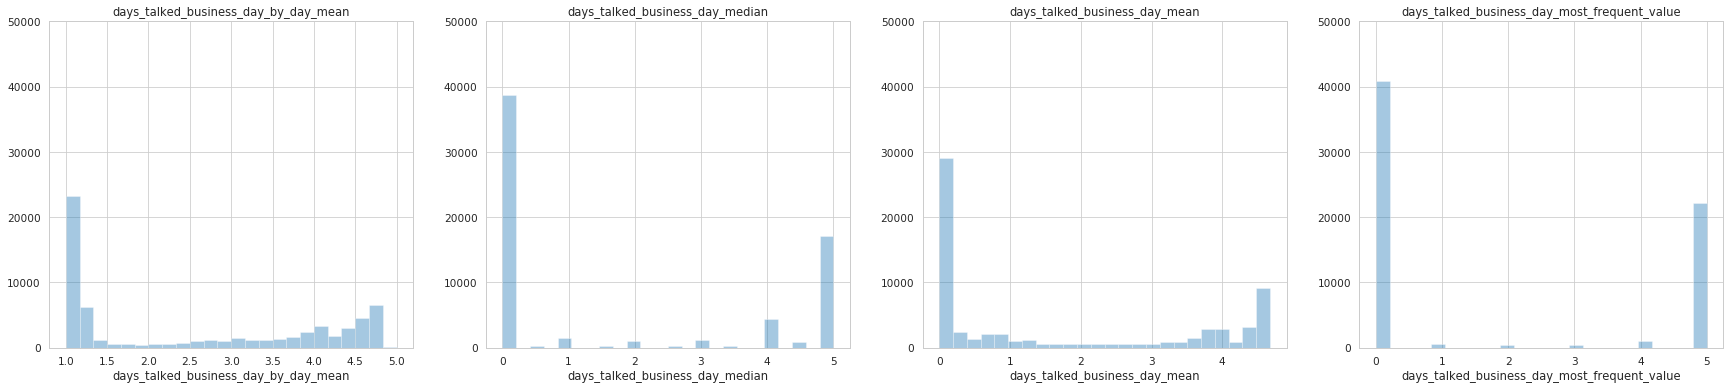

In [47]:
# Plot setup
f,axs = plt.subplots(1,4,figsize=(30,6))

# Plot all characteristics
cnt = 0
for statistics in statistics_business_days_talked:
    cnt += 1
    sns.distplot(ip_characteristics[statistics].dropna(), kde=False, bins=24,ax=axs[cnt-1])
    axs[cnt-1].set_title(statistics)
    axs[cnt-1].set_ylim(0, 50000)

plt.show()

Weekend days

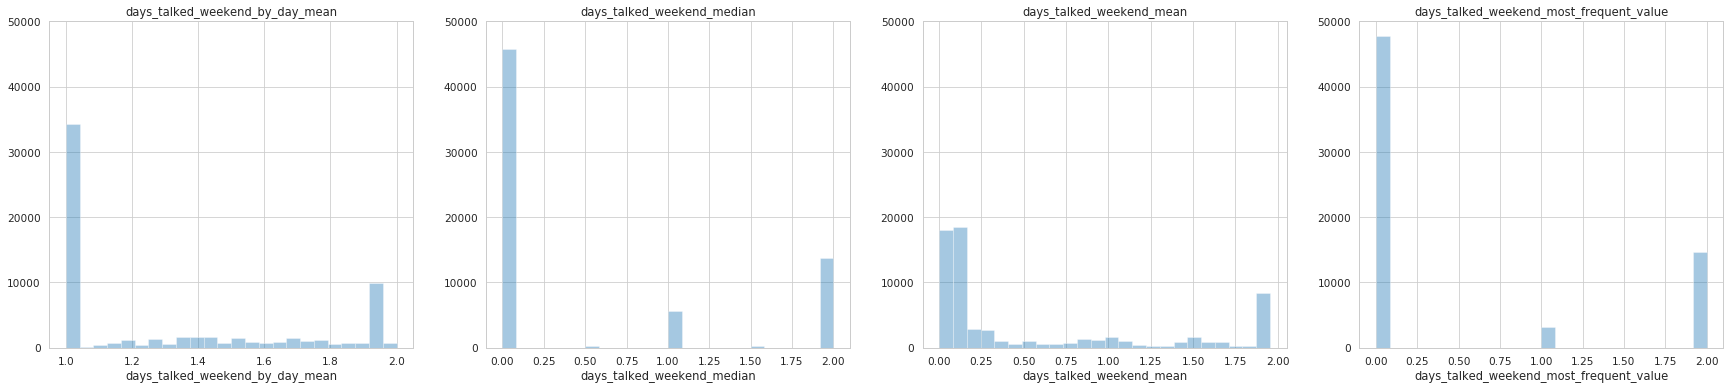

In [48]:
# Plot setup
f,axs = plt.subplots(1,4,figsize=(30,6))

# Plot all characteristics
cnt = 0
for statistics in statistics_weekend_days_talked:
    cnt += 1
    sns.distplot(ip_characteristics[statistics].dropna(), kde=False, bins=24,ax=axs[cnt-1])
    axs[cnt-1].set_title(statistics)
    axs[cnt-1].set_ylim(0, 50000)


plt.show()

Computation of the number of **Business Day Talkers** based on the **average number of days* communicated during the business days for different values of cutoff (0,1,2,...,5)

In [49]:
# Create dataframe for cutoff output and its columns
columns = ['Cutoff Day'] + [s +"_0" for s in statistics_business_days_talked] + [s +"_1" for s in statistics_business_days_talked]
cutoff_analysis_days_talked_business = pd.DataFrame(columns = columns)

# Iterate over different cutoffs
for cutoff in range(0,6,1):
    # Initialize record for cutoff dataframe
    record = {'Cutoff Day': cutoff}
    # Iterate over different aggregation statistics
    for statistics in statistics_business_days_talked:
        # Print progress
        clear_output(wait=True)
        print("Cutoff Day: %s  Statistics: %s " %(cutoff,statistics))
        # Label hosts based on the cutoff
        talker = ip_characteristics.apply(lambda row: label_business_weekend_talker(row,cutoff,statistics), axis =1)
        # Compute the number of labeled talkers
        value_counts= talker.value_counts()
        # Create the record
        if 0 in value_counts.keys():
            record[statistics + "_0"] = value_counts[0]    
        else:
            record[statistics + "_0"] = 0
        if 1 in value_counts.keys():
            record[statistics + "_1"]  = value_counts[1]
        else:
             record[statistics + "_1"] = 0
        
    cutoff_analysis_days_talked_business = cutoff_analysis_days_talked_business.append(pd.DataFrame(record, index = [1]), ignore_index=True)
print('Computation finished')

Cutoff Day: 5  Statistics: days_talked_business_day_most_frequent_value 
Computation finished


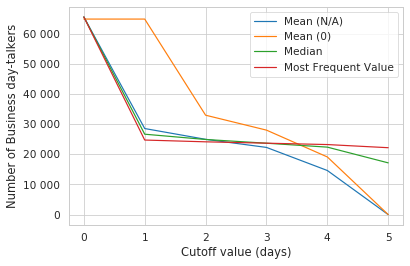

In [50]:
# Plot cutoff analysis results
## Set style
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2 )

## Plot data
sns_plot = sns.lineplot(x='Cutoff Day', y='days_talked_business_day_mean_1',data= cutoff_analysis_days_talked_business.astype(float), label = "Mean (N/A)")
sns_plot = sns.lineplot(x='Cutoff Day', y='days_talked_business_day_by_day_mean_1',data= cutoff_analysis_days_talked_business.astype(float), label = "Mean (0)")
sns_plot = sns.lineplot(x='Cutoff Day', y='days_talked_business_day_median_1',data= cutoff_analysis_days_talked_business.astype(float), label = "Median")
sns_plot = sns.lineplot(x='Cutoff Day', y='days_talked_business_day_most_frequent_value_1',data= cutoff_analysis_days_talked_business.astype(float), label = "Most Frequent Value")

## Adjust plot properties
ylabels = ['{:,.0f}'.format(y).replace(',', ' ') for y in sns_plot.get_yticks()]
sns_plot.set_yticklabels(ylabels)
sns_plot.set_xticks(np.arange(0, 6, step=1))
sns_plot.set(ylabel = "Number of Business day-talkers", xlabel="Cutoff value (days)")

## Show plot
#sns_plot.figure.savefig('./fig/Patterns-cutoff-weekday.svg')
plt.show()

Computation of the number of **Weekend Day Talkers** based on the **average number of days* communicated during the weekend days for different values of cutoff (0,1)

In [51]:
# Create dataframe for cutoff output and its columns
columns = ['Cutoff Day'] + [s +"_0" for s in statistics_weekend_days_talked] + [s +"_1" for s in statistics_weekend_days_talked]
cutoff_analysis_days_talked_weekend = pd.DataFrame(columns = columns)

# Iterate over different cutoffs
for cutoff in range(0,3,1):
    # Initialize record for cutoff dataframe
    record = {'Cutoff Day': cutoff}
    # Iterate over different aggregation statistics
    for statistics in statistics_weekend_days_talked:
        # Print progress
        clear_output(wait=True)
        print("Cutoff Day: %s  Statistics: %s " %(cutoff,statistics))
        # Label hosts based on the cutoff
        talker = ip_characteristics.apply(lambda row: label_business_weekend_talker(row,cutoff,statistics), axis =1)
        # Compute the number of labeled talkers
        value_counts= talker.value_counts()
        # Create the record
        if 0 in value_counts.keys():
            record[statistics + "_0"] = value_counts[0]    
        else:
            record[statistics + "_0"] = 0
        if 1 in value_counts.keys():
            record[statistics + "_1"]  = value_counts[1]
        else:
             record[statistics + "_1"] = 0
        
    cutoff_analysis_days_talked_weekend = cutoff_analysis_days_talked_weekend.append(pd.DataFrame(record, index = [1]), ignore_index=True)
print('Computation finished')

Cutoff Day: 2  Statistics: days_talked_weekend_most_frequent_value 
Computation finished


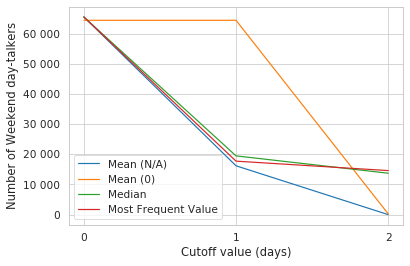

In [52]:
# Plot cutoff analysis results
## Set style
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2 )

## Plot data
sns_plot = sns.lineplot(x='Cutoff Day', y='days_talked_weekend_mean_1',data= cutoff_analysis_days_talked_weekend.astype(float), label = "Mean (N/A)")
sns_plot = sns.lineplot(x='Cutoff Day', y='days_talked_weekend_by_day_mean_1',data= cutoff_analysis_days_talked_weekend.astype(float), label = "Mean (0)")
sns_plot = sns.lineplot(x='Cutoff Day', y='days_talked_weekend_median_1',data= cutoff_analysis_days_talked_weekend.astype(float), label = "Median")
sns_plot = sns.lineplot(x='Cutoff Day', y='days_talked_weekend_most_frequent_value_1',data= cutoff_analysis_days_talked_weekend.astype(float), label = "Most Frequent Value")

## Adjust plot properties
ylabels = ['{:,.0f}'.format(y).replace(',', ' ') for y in sns_plot.get_yticks()]
sns_plot.set_yticklabels(ylabels)
sns_plot.set_xticks(np.arange(0, 3, step=1))
sns_plot.set(ylabel = "Number of Weekend day-talkers", xlabel="Cutoff value (days)")

## Show plot
#sns_plot.figure.savefig('./fig/Patterns-cutoff-weekday.svg')
plt.show()

#### Cutoff Analysis Based on the combination of Average Number of Days and Average Number of Hours Communicated During the Business Days/Weekend 

##### Business day

In [53]:
# Create dataframe for cutoff output and its columns
columns = ['Day', "Hour"] + [s +"_combined_0" for s in statistics_business] + [s +"_combined_1" for s in statistics_business]
cutoff_analysis_combined_business = pd.DataFrame(columns = columns)

# Iterate over different cutoffs
for hour in range(0,24,1):
    for day in np.arange(0,6,1):
        # Initialize record for cutoff dataframe
        record = {'Day': day, "Hour": hour}
        # Iterate over different aggregation statistics
        for statistics in statistics_business:
            # Print progress
            clear_output(wait=True)
            print("Hour: %s day: %s statistic: %s" %(hour, day, statistics))
            # Label hosts based on the cutoffs
            talker = ip_characteristics.apply(lambda row: label_business_weekend_talker_combined(row,hour,day,statistics), axis =1)
            # Compute the number of labelled talkers
            value_counts= talker.value_counts()
            # Create Record
            if 0 in value_counts.keys():
                record[statistics + "_combined_0"] = value_counts[0]    
            else:
                record[statistics + "_combined_0"] = 0
            if 1 in value_counts.keys():
                record[statistics + "_combined_1"]  = value_counts[1]
            else:
                 record[statistics + "_combined_1"] = 0
        
        cutoff_analysis_combined_business = cutoff_analysis_combined_business.append(pd.DataFrame(record, index = [1]), ignore_index=True)

print('Cell finished')

Hour: 23 day: 5 statistic: business_day_most_frequent_value
Cell finished


Weekend

In [54]:
# Create dataframe for cutoff output and its columns
columns = ['Day', "Hour"] + [s +"_combined_0" for s in statistics_weekend] + [s +"_combined_1" for s in statistics_weekend]
cutoff_analysis_combined_weekend = pd.DataFrame(columns = columns)

# Iterate over different cutoffs
for hour in range(0,24,1):
    for day in np.arange(0,2,1):
        # Initialize record for cutoff dataframe
        record = {'Day': day, "Hour": hour}
        # Iterate over different aggregation statistics
        for statistics in statistics_weekend:
            # Print progress
            clear_output(wait=True)
            print("Hour: %s day: %s statistic: %s" %(hour, day, statistics))
            # Label hosts based on the cutoffs
            talker = ip_characteristics.apply(lambda row: label_business_weekend_talker_combined(row,hour,day,statistics), axis =1)
            # Compute the number of labelled talkers
            value_counts= talker.value_counts()
            # Create Record
            if 0 in value_counts.keys():
                record[statistics + "_combined_0"] = value_counts[0]    
            else:
                record[statistics + "_combined_0"] = 0
            if 1 in value_counts.keys():
                record[statistics + "_combined_1"]  = value_counts[1]
            else:
                 record[statistics + "_combined_1"] = 0
        
        cutoff_analysis_combined_weekend = cutoff_analysis_combined_weekend.append(pd.DataFrame(record, index = [1]), ignore_index=True)

print('Cell finished')

Hour: 23 day: 1 statistic: weekend_most_frequent_value
Cell finished


##### Combine day and weekend, plot results

In [55]:
# Transfer to percentage of total values
cutoff_analysis_combined_business_percent = cutoff_analysis_combined_business.copy()
cutoff_analysis_combined_business_percent = cutoff_analysis_combined_business_percent.astype('float64')
cutoff_analysis_combined_business_percent.loc[:, ~cutoff_analysis_combined_business_percent.columns.isin(['Day', "Hour"])] = cutoff_analysis_combined_business_percent.loc[:, ~cutoff_analysis_combined_business_percent.columns.isin(['Day', "Hour"])]/65536*100

cutoff_analysis_combined_weekend_percent =  cutoff_analysis_combined_weekend.copy()
cutoff_analysis_combined_weekend_percent = cutoff_analysis_combined_weekend_percent.astype('float64')
cutoff_analysis_combined_weekend_percent.loc[:, ~cutoff_analysis_combined_weekend_percent.columns.isin(['Day', "Hour"])] = cutoff_analysis_combined_weekend_percent.loc[:, ~cutoff_analysis_combined_weekend_percent.columns.isin(['Day', "Hour"])]/65536*100

Statistic: by_day_mean


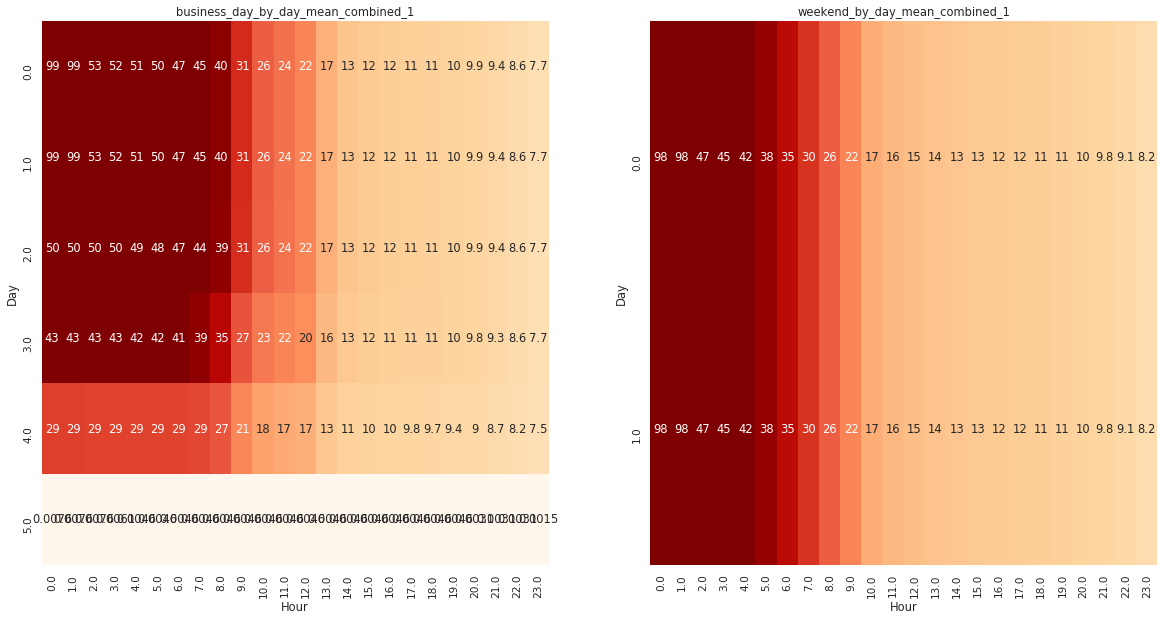

Statistic: mean


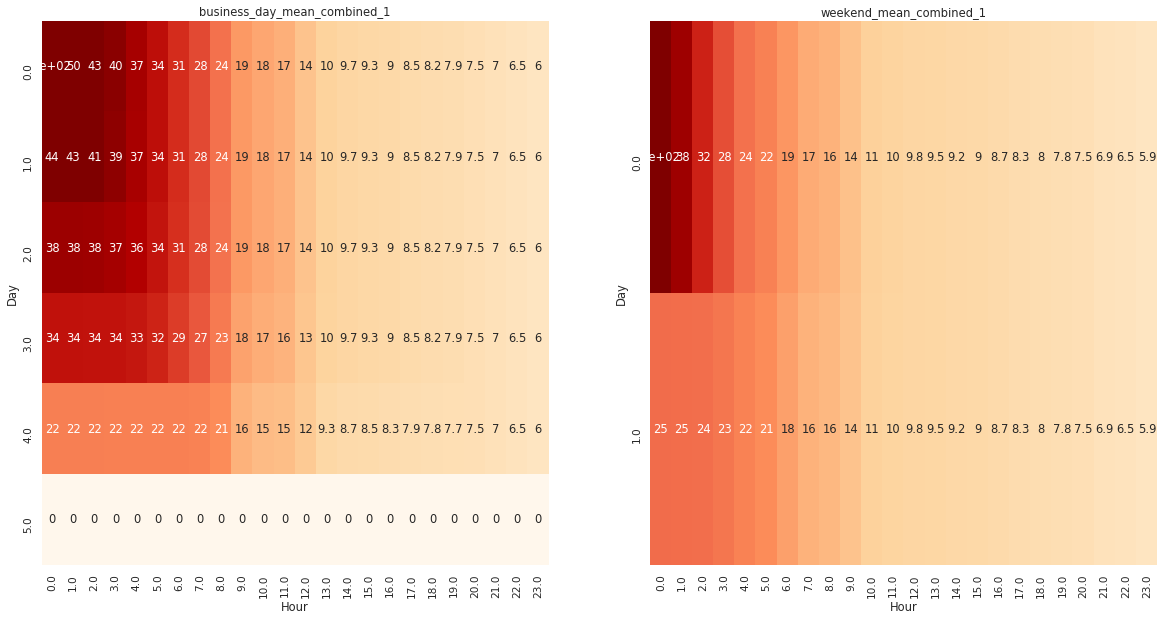

Statistic: median


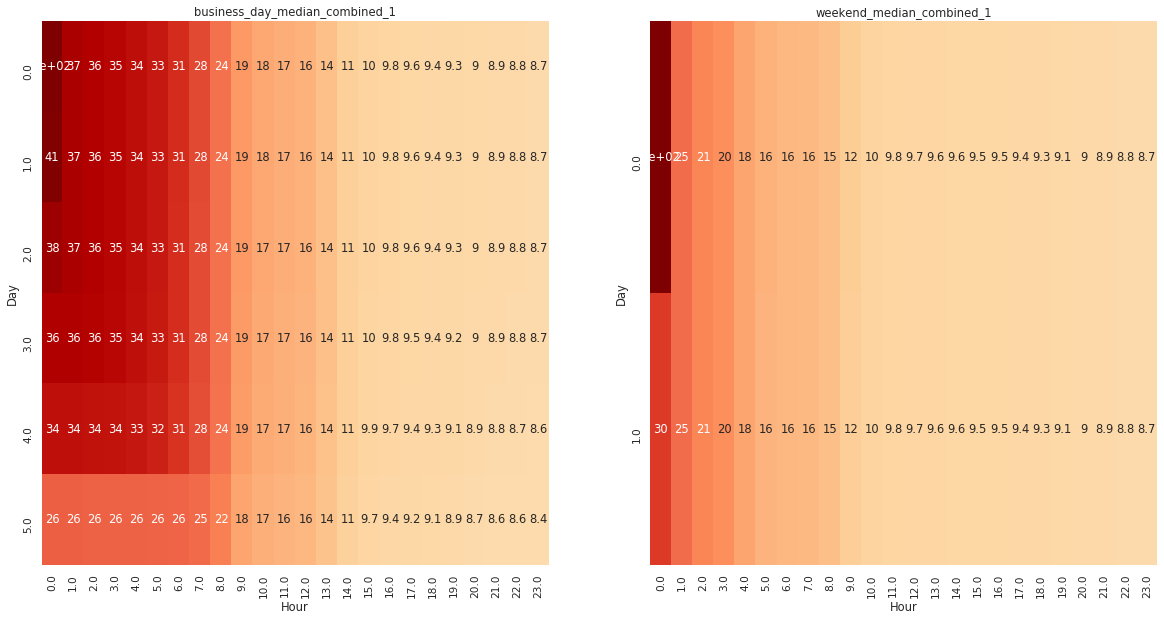

Statistic: most_frequent_value


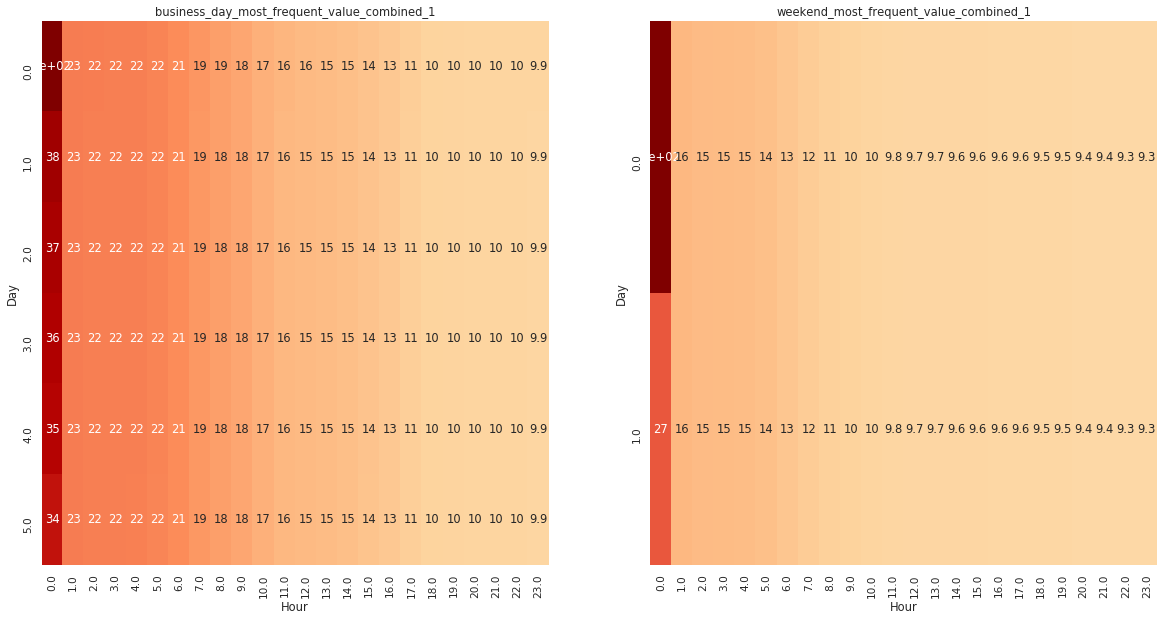

In [56]:
# Set plot style
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2 )
maxi = 41
cmap =  "OrRd"
#cmap = "OrRd" "RdBu_r"

# Iterate over the statistics
for statistic in ['by_day_mean', 'mean', 'median', 'most_frequent_value']:
    
    business_statistics = 'business_day_' + statistic + '_combined_1'
    weekend_statistics = 'weekend_' + statistic + '_combined_1'
    
    # Print Computed statistics
    print("Statistic: %s" %(statistic))        
    
    # Create heat map values
    heat_map_business = cutoff_analysis_combined_business_percent.pivot('Day','Hour', business_statistics)
    heat_map_weekend = cutoff_analysis_combined_weekend_percent.pivot('Day','Hour', weekend_statistics)
    
    # Plot the values
    f,axs = plt.subplots(1,2,figsize=(20,10))
    ## Business
    sns.heatmap(heat_map_business, cmap = cmap, ax=axs[0],cbar=False, annot=True, vmin=0, vmax=maxi)
    axs[0].set_title(business_statistics)
    ## Weekend
    sns.heatmap(heat_map_weekend, cmap = cmap, ax=axs[1],cbar=False, annot=True, vmin=0, vmax=maxi)
    axs[1].set_title(weekend_statistics)
    
    # Show plot
    plt.show()

Assign labels based on the selected cutoff

In [57]:
ip_characteristics['business_day_talker'] = ip_characteristics.apply(lambda row: weighted_label_business_weekend_talker_combined(row,8,3,statistics_business), axis =1)
ip_characteristics['weekend_talker'] = ip_characteristics.apply(lambda row: weighted_label_business_weekend_talker_combined(row,8,1, statistics_weekend), axis =1)
ip_characteristics['all_week_talker'] = ip_characteristics.apply(lambda row: label_all_week_talker(row), axis =1)
ip_characteristics['no_talker'] = ip_characteristics.apply(lambda row: no_talker(row), axis =1)
ip_characteristics['business_day_talker_only'] = ip_characteristics.apply(lambda row: business_day_talker_only(row), axis =1)
ip_characteristics['weekend_talker_only'] = ip_characteristics.apply(lambda row: weekend_talker_only(row), axis =1)

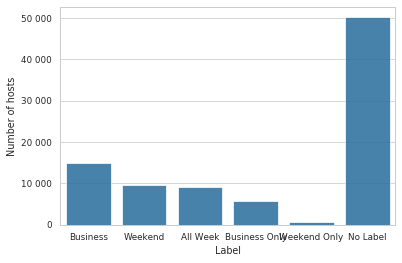

In [58]:
# Plot the restulting distribution of the labels
## Prepare data for ploting
bar=ip_characteristics[['business_day_talker', 'weekend_talker',
       'all_week_talker',  'business_day_talker_only', 'weekend_talker_only', 'no_talker']]

arrays = []
for char in bar.columns:
    counts = bar[char].value_counts()

    array=[0]*3
    array[0] = char
    array[1] = "yes"
    array[2] = counts[1]
    arrays.append(array)
    array=[0]*3
    array[0] = char
    array[1] = "no"
    array[2] = counts[0]
    arrays.append(array)    
df_bar = pd.DataFrame(arrays, columns=['char', 'Label', 'count'])

## Set plot style
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1)

## Plot the data
sns_plot = sns.barplot(x='char',y='count', data=df_bar[df_bar['Label']=='yes'],  color = '#1F77B4', alpha=0.9)

## Adjust plot properties
ylabels = ['{:,.0f}'.format(y).replace(',', ' ') for y in sns_plot.get_yticks()]
sns_plot.set_yticklabels(ylabels)
sns_plot.set_xticklabels(['Business', 'Weekend',
       'All Week',  'Business Only', 'Weekend Only', 'No Label'])
sns_plot.set(ylabel = "Number of hosts", xlabel="Label")

## Show plot
#sns_plot.figure.savefig('./fig/Pattern_day_night_value_counts.svg')
plt.show()